# Derivatives with Gaussian Processes

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from nuclear_matter import fermi_momentum, nuclear_density
from nuclear_matter import compute_pressure, compute_pressure_cov
from nuclear_matter import compute_slope, compute_slope_cov
from nuclear_matter import compute_compressibility, compute_compressibility_cov
from nuclear_matter import compute_speed_of_sound
from nuclear_matter import setup_rc_params
from nuclear_matter import InputData
from nuclear_matter import confidence_ellipse, confidence_ellipse_mean_cov

import corner

# To use gptools with Python 3, clone from GitHub repository 
#   https://github.com/markchil/gptools 
# and install with 'pip install .' from inside repo. 
import gptools

import time

In [2]:
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['figure.dpi'] = 130
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['ytick.direction'] = 'in'
# mpl.rcParams['xtick.direction'] = 'in'
# mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')
setup_rc_params()

In [3]:
COLOR_68 = 'darkgrey'   # color for 1 sigma bands
COLOR_95 = 'lightgrey'  # color for 2 sigma bands

def curve_plus_bands_plot(ax, x, y, std, 
                          color_68=None, color_95=None, zorder=None, **kwargs):
    """
    Plot y vs. x with one sigma and two sigma bands based on std on axis ax.
     Add any other keyword pairs to style the main curve.
    """
    if color_68 is None:
        color_68 = COLOR_68
    if color_95 is None:
        color_95 = COLOR_95
    ax.plot(x, y, zorder=zorder, **kwargs)
    ax.fill_between(x, y + 2*std, y - 2*std, color=color_95, zorder=zorder)
    ax.fill_between(x, y + std, y - std, color=color_68, zorder=zorder)


## Standard Case

We have data and would like to find a function that best captures the relationship between the inputs and outputs.
A popular nonparametric tool for regression is a Gaussian process (GP).
One of the neat things about a GP is that you automatically get uncertainty quantification along with the line of best fit.
But what is less well known is that it also provides derivatives of the best fit line, and corresponding uncertainty estimates, for free!

The derivative is a linear operator, so the distributions for derivatives follow similarly to how one transforms a Gaussian random variable by scalars or matrices.
Suppose $f$ is distributed as a ($n$-dimensional, for genalizability) Gaussian random variable,
\begin{align}
    f \sim N(0, \Sigma).
\end{align}
Then for some $N\times n$ matrix $C = [1, D]^T$,
\begin{align}
    C f = \begin{bmatrix} 1 \\ D \end{bmatrix} f
    \sim N(0, C \Sigma C^T)
\end{align}
Suppose now that $D = d/dx$ and $f$ is some function of $x$, distributed as a Gaussian process:
\begin{align}
    f(x) \sim GP[0, \kappa(x, x')].
\end{align}
The above logic allows us to find how $f$ correlates with its derivative:
\begin{align}
    \begin{bmatrix} f(x) \\ f'(x) \end{bmatrix}
    & \sim GP[0, K(x, x')] \\
    K(x, x') & =
    \begin{bmatrix}
        K_{00}(x, x') & K_{01}(x, x') \\
        K_{10}(x, x') & K_{11}(x, x')
    \end{bmatrix} =
    \begin{bmatrix}
        \kappa(x, x') & \frac{d}{dx'}\kappa(x, x') \\
        \frac{d}{dx}\kappa(x, x') & \frac{d^2}{dxdx'}\kappa(x, x')
    \end{bmatrix}
\end{align}
It will be useful later to know how to add a function with its derivative, while propagating uncertainties.
For this, we will need
\begin{align}
    Af + Bf' \sim GP[0, AK_{00}A^T + BK_{11}B^T + AK_{01}B^T + BK_{10}A^T]
\end{align}

### Fitting a function f(x)

Let's check out how it works. Start by creating some data with noise.

In [4]:
from sympy import symbols, diff, sqrt, lambdify
def f(x, n=0): # the n-th derivative of the function
    xi = symbols('xi')
    function = xi**2 # define function here
    fx = lambdify(xi, diff(function,xi,n), "numpy")
    return fx(x)*np.ones(len(x)) # make sure returned/input array has same length

In [5]:
x = np.linspace(0, 1, 20)
x_star = np.linspace(0, 1, 100)

#np.random.seed(1)
np.random.seed(None)  # different data every time

std = 0.1 # standard deviation for noise
y = f(x) + stats.norm(scale=std).rvs(len(x))

Now plot the true line and the data we will use to fit our curve.

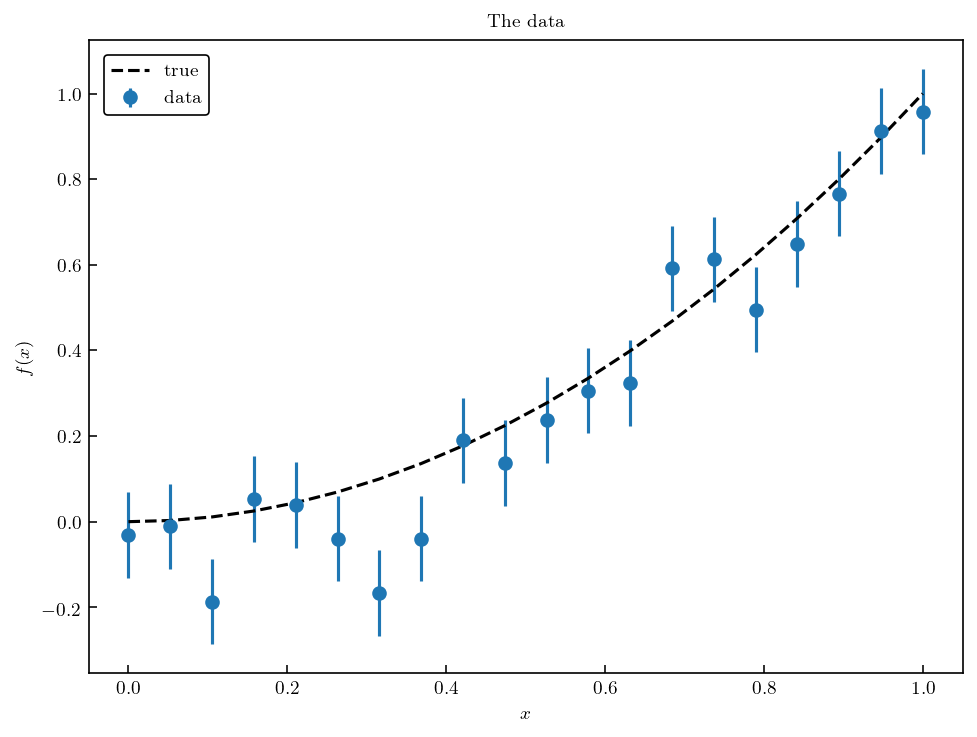

In [6]:
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The data")
plt.legend();

To use a GP, we need to convert the 1d `x` input into an `NxD` matrix (since GPs can live in a `D` dimensional space, in general).
This is a `D=1` dimensional space in this example.

In [7]:
X = x[:, None]
X_star = x_star[:, None]

Begin by creating the kernel, which quantifies the correlation structure (smoothness properties) of the curves.
Then feed the kernel into a GP object, and fit it to the data we plotted above.
The radial basis function kernel (i.e., the Squared Exponential) has two hyperparameters that it depends on: the marginal variance and length scale.
Let's let the data decide which hyperparameters provide the best fit, via optimization.

In [8]:
# rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1,1], fixed_params=[True, True])
rbf_kernel = gptools.SquaredExponentialKernel(initial_params=[1.,1.], param_bounds=[(1e-9, 2), (1e-9, 2)])
gp = gptools.GaussianProcess(rbf_kernel)
gp.add_data(X, y, err_y=std)
gp.optimize_hyperparameters(max_tries=10)

(     fun: 26.414650586992792
      jac: array([ 0.00129056, -0.00662637])
  message: 'Optimization terminated successfully.'
     nfev: 66
      nit: 14
     njev: 14
   status: 0
  success: True
        x: array([0.69692031, 0.65477766]),
 12)

That's it! Now we can get the curve of best fit and its uncertainty.

In [9]:
y_star, std_star = gp.predict(X_star, return_std=True)

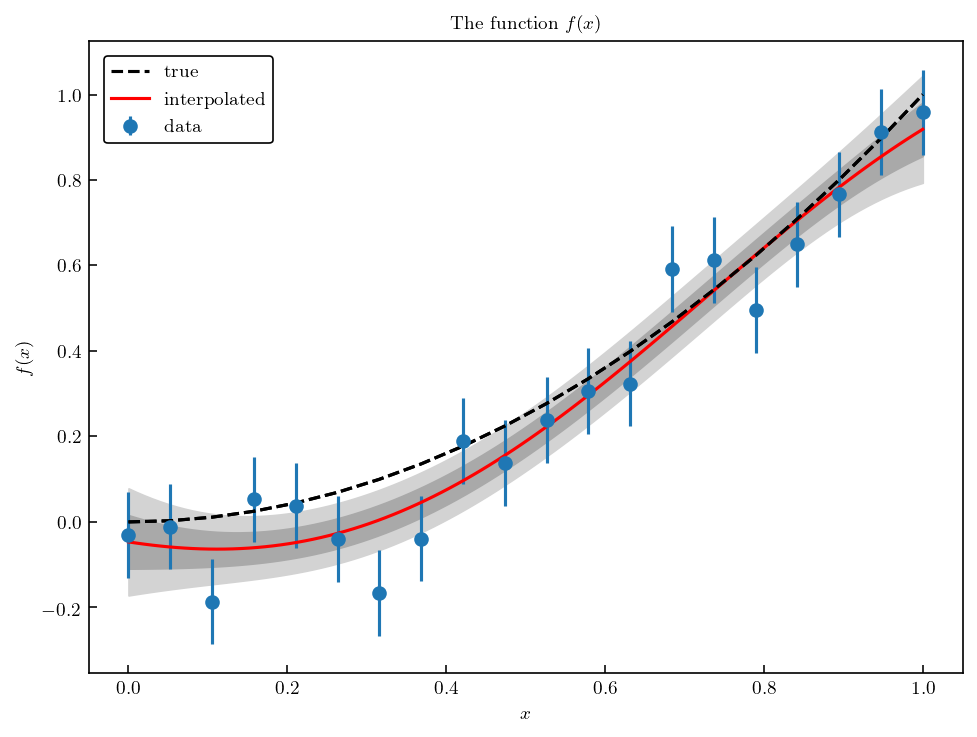

In [10]:
# set up figure
fig, ax = plt.subplots(1, 1)

# plot the data
plt.plot(x, f(x), c='k', ls='--', label='true')
plt.errorbar(x, y, std, ls='', marker='o', label='data')

# plot GP
y_star, std_star = gp.predict(X_star, return_std=True)
curve_plus_bands_plot(ax, x_star, y_star, std_star, c='r', label='interpolated')

# plot the function
plt.plot(x, f(x), c='k', ls='--')

# labels
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title("The function $f(x)$")
plt.legend();

### Estimating the derivative f'(x)

Since our function is simple, we can take its derivative analytically (e.g., using SymPy) and compare to our approximation. `GPTools` allows for predicting derivatives very easily! Just use `n=1` in the `predict` method to compute the first derivative.

In [11]:
derivOrder = 1 # order of the derivative
y_prime_star, std_prime_star = gp.predict(X_star, n=derivOrder, return_std=True)

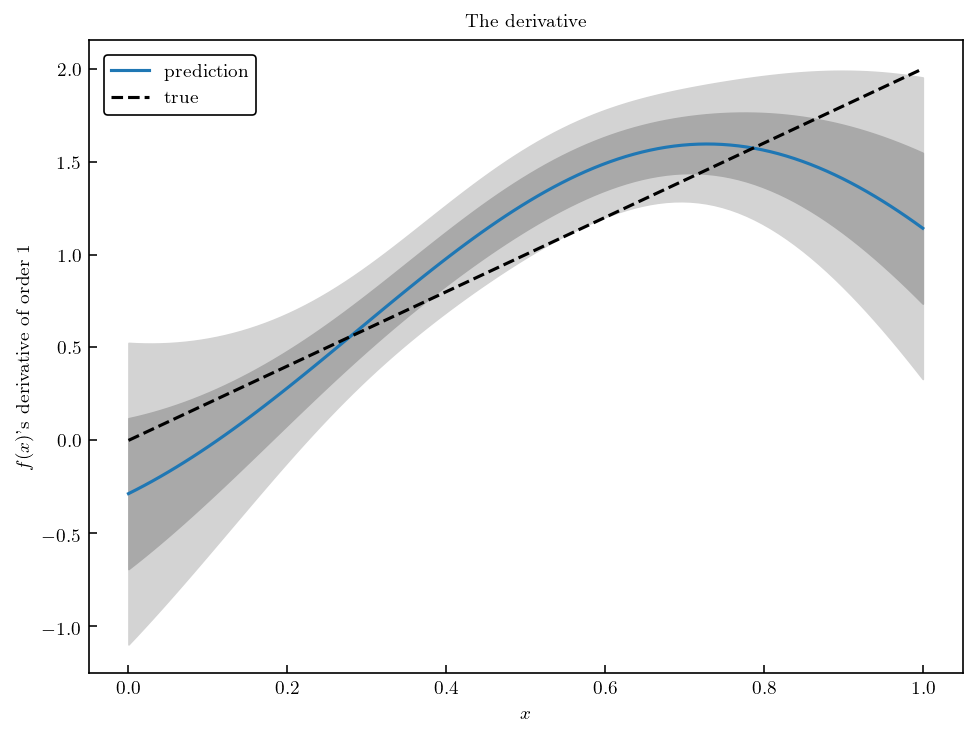

In [12]:
fig, ax = plt.subplots(1, 1)
curve_plus_bands_plot(ax, x_star, y_prime_star, std_prime_star, label="prediction")
plt.plot(x, f(x, derivOrder), c='k', ls='--', label="true")

plt.title("The derivative")
plt.xlabel('$x$');
plt.ylabel(f"$f(x)$'s derivative of order {derivOrder}")
plt.legend();

In [13]:
def draw_func_and_derivative(Xstar, kernel, X=None, y=None, err_y=None, draws=1, extra_kernel=None):
    n = Xstar.shape[0]
    XsXs = np.concatenate((Xstar, Xstar), axis=0)
    derivs = np.concatenate((np.zeros(Xstar.shape), np.ones(Xstar.shape)), axis=0)

    gp = gptools.GaussianProcess(k=kernel)
    if X is not None and y is not None:
        gp.add_data(X, y, err_y=err_y)
        gp.optimize_hyperparameters(max_tries=10)
        mean, K = gp.predict(XsXs, n=derivs, return_cov=True)
    else:
        K = gp.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)
        mean = np.zeros(2*n)
        
    if extra_kernel is not None:  # We will use this for the truncation error later
        gp_extra = gptools.GaussianProcess(k=extra_kernel)
        K += gp_extra.compute_Kij(XsXs, XsXs, ni=derivs, nj=derivs)

    # The draw_sample function is much more numerically stable than
    # just using stats.multivariate_normal
    # Since we pass mean and cov, the first arguments aren't used.
    samples = gp.draw_sample(XsXs, derivs, mean=mean, cov=K, num_samp=draws)  # shape = (2n, draws)
    return samples.reshape(2, n, draws)  # separate f and f_prime by first dimension

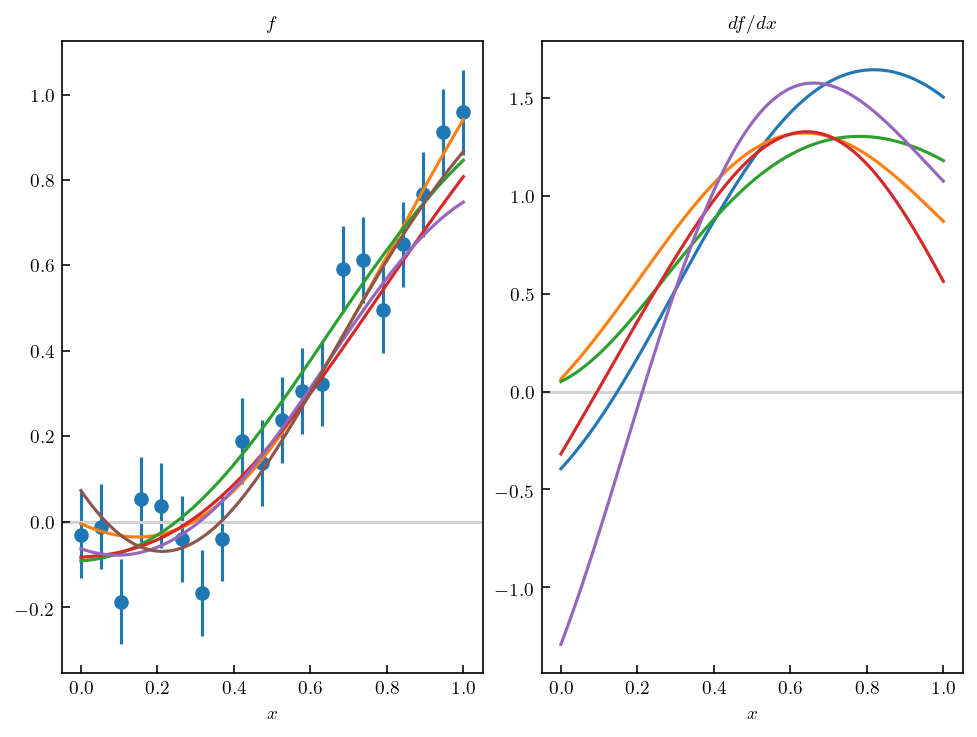

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2)

rbf_kernel_short = gptools.SquaredExponentialKernel(initial_params=[1, 0.25], param_bounds=[(1e-9, 2), (1e-9, 2)])

x_pred = np.linspace(0, 1, 100)


# Draw samples from fitted GP:

f_draw, fp_draw = draw_func_and_derivative(
    x_pred[:, None], rbf_kernel_short, X=X, y=y, err_y=std, draws=5)
ax1.errorbar(x, y, std, ls='', marker='o', label='data', zorder=0)


# Draw samples from unfitted GP:

# f_draw, fp_draw = draw_func_and_derivative(
#     x_pred[:, None], rbf_kernel_short, draws=5)


ax1.plot(x_pred, f_draw)
ax2.plot(x_pred, fp_draw)
ax1.set_title('$f$')
ax2.set_title('$df/dx$')
ax1.set_xlabel('$x$')
ax2.set_xlabel('$x$')
ax1.axhline(0, 0, 1, c='lightgrey', zorder=0)
ax2.axhline(0, 0, 1, c='lightgrey', zorder=0);

# Nuclear Matter Application

Our specific use case is similar to the example above: we fit a GP to data, in this case from a physics simulation.
But there is one additional source of uncertainty from the theory error. This will also involve us creating our own custom GP kernel!

Start again by getting some data.

In [15]:
# Lambda = 450
Lambda = 500

high_density = False
if high_density:
    filename = '../data/all_matter_data_high_density.csv'
else:
    filename = '../data/all_matter_data.csv'
    
data = InputData(filename, Lambda, high_density)


In [16]:
orders = np.array([0, 2, 3, 4])
train = slice(None, None, 5)
valid = slice(2, None, 5)

breakdown = 600

In [17]:
# orders = np.array([0, 2, 3, 4])
# body = 'NN-only'
# body = 'NN+3N'
# Lambda = 450
# fits = {450: [1, 7], 500: [4, 10]}
# train = slice(None, None, 5)
# valid = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
# [fit_n2lo, fit_n3lo] = fits[Lambda]

# excluded = np.array([1])

# savefigs = False

# mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

# mask1 = \
#     (df['Body'] == body) & \
#     mask_fit & \
#     (df['Lambda'] == Lambda)


# # df_fit = df[mask_fit]
# df_n = df[mask1 & (df['x'] == 0)] 
# df_s = df[mask1 & (df['x'] == 0.5)] 

# kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values # Fermi momentum in neutron matter
# kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values # Fermi momentum in symmetric matter
# density = df_n[df_n['OrderEFT'] == 'LO']['n'].values # density
# kf_d = kf_n.copy() # Fermi momentum associated with the symmetry energy

# # valid1 = np.arange(len(kf_n)) % 5 != 0

# Kf_n = kf_n[:, None]
# Kf_s = kf_s[:, None]
# Kf_d = kf_d[:, None]

# y_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in df_n['OrderEFT'].unique()]).T # E/N
# y_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T # E/A
# y_d = y_n - y_s # symmetry energy

In [18]:
kf_n = data.kf_n
Kf_n = data.Kf_n
kf_s = data.kf_s
Kf_s = data.Kf_s
kf_d = data.kf_avg
Kf_d = data.Kf_avg

density = data.density

ref_2bf = data.ref_2bf
ref_n_3bf = data.ref_n_3bf
ref_s_3bf = data.ref_s_3bf
ref_d_3bf = data.ref_avg_3bf

y_s_2_plus_3bf = data.y_s_2_plus_3bf
y_n_2_plus_3bf = data.y_n_2_plus_3bf
y_d_2_plus_3bf = data.y_d_2_plus_3bf

y_s_2bf = data.y_s_2bf
y_n_2bf = data.y_n_2bf
y_d_2bf = data.y_d_2bf

y_s_3bf = data.y_s_3bf
y_n_3bf = data.y_n_3bf
y_d_3bf = data.y_d_3bf

fit_n2lo = data.fit_n2lo
fit_n3lo = data.fit_n3lo

Visualize the EOS.

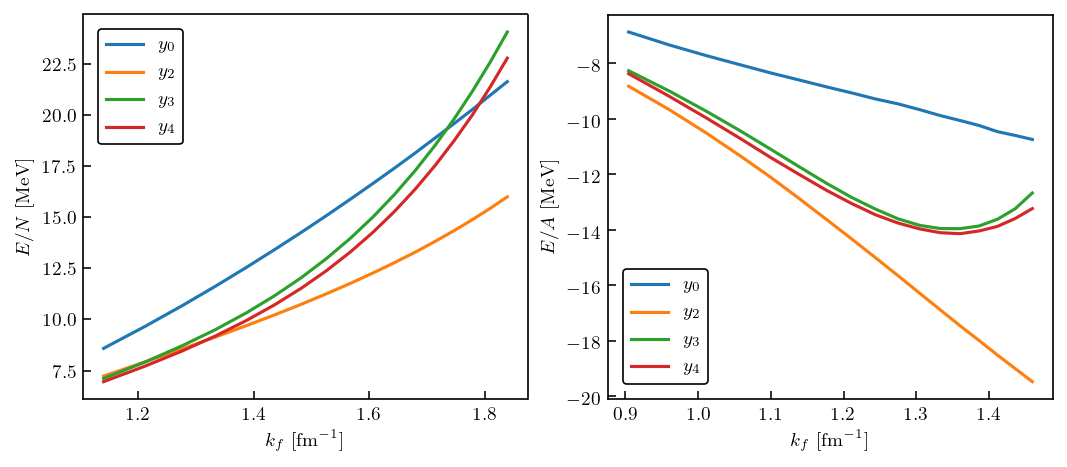

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
# fig.tight_layout(pad=2.5) 

# first neutron matter
for i, n in enumerate(orders):
    ax[0].plot(kf_n, y_n_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[0].legend()
ax[0].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[0].set_ylabel(r'$E/N$ [MeV]');

# then symmetric matter
for i, n in enumerate(orders):
    ax[1].plot(kf_s, y_s_2_plus_3bf[:, i], label=fr'$y_{n}$')
ax[1].legend()
ax[1].set_xlabel(r'$k_f$ [fm$^{-1}$]')
ax[1].set_ylabel(r'$E/A$ [MeV]');

The kernel for our GP convergence model is not a simple RBF, it must be multiplied by factors related to the converges of the EFT:

\begin{align}
    \kappa(x, x';\bar c, \ell) = y_{\text{ref}}(x)y_{\text{ref}}(x') \frac{[Q(x)Q(x')]^{k+1}}{1-Q(x)Q(x')} \bar c^2 r(x,x';\ell)
\end{align}

where $\bar c^2 r(x,x';\ell)$ is the RBF kernel used above.
GPTools can handle products of kernels, so we just need to create a kernel object that represents the prefactor above.
I'm still not completely sure how to make a truly compatible kernel object, but the code below seems to do the trick.

In [20]:
# from gptools import ArbitraryKernel

We need to take arbitrary numbers of derivatives. Humans can make mistakes, let `SymPy` handle it.

Finally, we can create the kernel objects for our GP interpolation and derivatives. Assume some values for the hyperparameters, these would come from our convergence analysis of the observable coefficients.

In [21]:
# from functools import partial

# k_max = 4
# # eval_kernel_lower = partial(eval_kernel_scale, lowest_order=0, highest_order=k_max)
# # eval_kernel_upper = partial(eval_kernel_scale, lowest_order=k_max+1)
# eval_kernel_lower = ConvergenceKernel(lowest_order=0, highest_order=k_max)
# eval_kernel_upper = ConvergenceKernel(lowest_order=k_max+1)

# matter_rbf_kernel_n = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])
# matter_rbf_kernel_s = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])
# matter_rbf_kernel_d = gptools.SquaredExponentialKernel(
#     initial_params=[1,1], fixed_params=[True, True])

# kernel_lower_n = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_n
# kernel_upper_n = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_n

# kernel_lower_s = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_s
# kernel_upper_s = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_s

# kernel_lower_d = CustomKernel(eval_kernel_lower) * matter_rbf_kernel_d
# kernel_upper_d = CustomKernel(eval_kernel_upper) * matter_rbf_kernel_d


In [22]:
N_all = 81
density_all = np.linspace(density[0], density[-1], N_all)

#neutron matter
# kf_n_all = np.linspace(kf_n[0], kf_n[-1], N_all)
kf_n_all = fermi_momentum(density_all, degeneracy=2)
Kf_n_all = kf_n_all[:, None]

#symmetric matter
# kf_s_all = np.linspace(kf_s[0], kf_s[-1], N_all)
kf_s_all = fermi_momentum(density_all, degeneracy=4)
Kf_s_all = kf_s_all[:, None]

#symmetry energy
# kf_d_all = np.linspace(kf_d[0], kf_d[-1], N_all)
kf_d_all = (kf_n_all + kf_s_all) / 2.
Kf_d_all = kf_d_all[:, None]

In [23]:
density_all

array([0.05 , 0.052, 0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066,
       0.068, 0.07 , 0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084,
       0.086, 0.088, 0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102,
       0.104, 0.106, 0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 ,
       0.122, 0.124, 0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138,
       0.14 , 0.142, 0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156,
       0.158, 0.16 , 0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174,
       0.176, 0.178, 0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192,
       0.194, 0.196, 0.198, 0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 ])

Begin by interpolating the data points we plotted above. This does not include truncation error yet. Also compute its derivative as before.

In [24]:
from nuclear_matter.derivatives import ObservableContainer

In [25]:
min_uncertainty = 0.02  # Twenty keV

In [26]:
err_y_n = np.abs(y_n_2_plus_3bf[:, -1]) * 0.005
err_y_n[np.abs(err_y_n) < min_uncertainty] = min_uncertainty
err_y_n

array([0.0347864 , 0.03856525, 0.0422416 , 0.045929  , 0.04969965,
       0.05359435, 0.05765975, 0.06195895, 0.06651935, 0.0713414 ,
       0.07645685, 0.08189105, 0.08765365, 0.0937225 , 0.1000547 ,
       0.10685755, 0.1139128 ])

In [27]:
err_y_s = np.abs(y_s_2_plus_3bf[:, -1]) * 0.005
err_y_s[np.abs(err_y_s) < min_uncertainty] = min_uncertainty
err_y_s

array([0.04184263, 0.04598362, 0.0498664 , 0.05352534, 0.0570013 ,
       0.06006317, 0.06286701, 0.0652531 , 0.06728271, 0.06878063,
       0.06983071, 0.07051881, 0.07069568, 0.07019797, 0.06937815,
       0.067951  , 0.0661693 ])

In [28]:
err_y_d = np.abs(y_d_2_plus_3bf[:, -1]) * 0.005
err_y_d[np.abs(err_y_d) < min_uncertainty] = min_uncertainty
err_y_d

array([0.07662903, 0.08454887, 0.09210799, 0.09945434, 0.10670096,
       0.11365752, 0.12052676, 0.12721204, 0.13380206, 0.14012204,
       0.14628756, 0.15240986, 0.15834933, 0.16392046, 0.16943285,
       0.17480855, 0.1800821 ])

In [29]:
err_y_n = err_y_s = err_y_d = 1e-2


In [30]:
setup_time_start = time.time()
verbose = True

print('Setting up neutron matter...', flush=True)
obs_neutron = ObservableContainer(
    density=density,
    kf=kf_n,
    y=y_n_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_n_all,
    std=0.745,
    ls=0.783,
    breakdown=breakdown,
    err_y=err_y_n,
    derivs=[0, 1, 2],
    verbose=verbose,
)

print('Setting up nuclear matter...', flush=True)
obs_nuclear = ObservableContainer(
    density=density,
    kf=kf_s,
    y=y_s_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_s_all,
    std=2.43,
    ls=0.404,
    breakdown=breakdown,
    err_y=err_y_s,
    derivs=[0, 1, 2],
    verbose=verbose,
)

print('Setting up symmetry energy...', flush=True)
obs_sym_energy = ObservableContainer(
    density=density,
    kf=kf_d,
    y=y_d_2_plus_3bf,
    orders=orders,
    density_interp=density_all,
    kf_interp=kf_d_all,
    std=0.7968,
    ls=0.371,
    breakdown=breakdown,
    err_y=err_y_d,
    derivs=[0, 1, 2],
    verbose=verbose,
)

print('Setup time:', time.time() - setup_time_start)

Setting up neutron matter...
For EFT order 0, the best polynomial has max nu = 4
For EFT order 2, the best polynomial has max nu = 5
For EFT order 3, the best polynomial has max nu = 6
For EFT order 4, the best polynomial has max nu = 6
Setting up nuclear matter...
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 6
For EFT order 4, the best polynomial has max nu = 7
Setting up symmetry energy...
For EFT order 0, the best polynomial has max nu = 7
For EFT order 2, the best polynomial has max nu = 6
For EFT order 3, the best polynomial has max nu = 6
For EFT order 4, the best polynomial has max nu = 7
Setup time: 18.982428073883057


In [31]:
# #neutron matter
# gp_n_lower = gptools.GaussianProcess(kernel_lower_n)
# gp_n_lower.add_data(Kf_n, y_n_2_plus_3bf[:, -1], err_y=1e-5)

# #symmetric matter
# gp_s_lower = gptools.GaussianProcess(kernel_lower_s)
# gp_s_lower.add_data(Kf_s, y_s_2_plus_3bf[:, -1], err_y=1e-5)

# #symmetry energy
# gp_d_lower = gptools.GaussianProcess(kernel_lower_d)
# gp_d_lower.add_data(Kf_d, y_d_2_plus_3bf[:, -1], err_y=1e-5)

In [32]:
# y_n_star_all_derivs, cov_n_star_all_derivs = predict_with_derivatives(
#     gp=gp_n_lower, X=Kf_n_all, n=[0, 1, 2], return_cov=True
# )

# y_s_star_all_derivs, cov_s_star_all_derivs = predict_with_derivatives(
#     gp=gp_s_lower, X=Kf_s_all, n=[0, 1, 2], return_cov=True
# )

# y_d_star_all_derivs, cov_d_star_all_derivs = predict_with_derivatives(
#     gp=gp_d_lower, X=Kf_d_all, n=[0, 1, 2], return_cov=True
# )

In [33]:
# y_n_star_all_derivs.shape

In [34]:
# extract_blocks(cov_n_star_all_derivs, (N_all, N_all)).shape

But now we can create the additional source of uncertainty due to EFT truncation.
Create both the error term for the interpolant and for its derivative.

In [35]:
# gp_n_upper = gptools.GaussianProcess(kernel_upper_n)
# cov_n_upper_all_derivs = predict_with_derivatives(
#     gp=gp_n_upper, X=Kf_n_all, n=[0, 1, 2], only_cov=True
# )

# gp_s_upper = gptools.GaussianProcess(kernel_upper_s)
# cov_s_upper_all_derivs = predict_with_derivatives(
#     gp=gp_s_upper, X=Kf_s_all, n=[0, 1, 2], only_cov=True
# )

# gp_d_upper = gptools.GaussianProcess(kernel_upper_d)
# cov_d_upper_all_derivs = predict_with_derivatives(
#     gp=gp_d_upper, X=Kf_d_all, n=[0, 1, 2], only_cov=True
# )

In [36]:
# cov_n_total_all_derivs = cov_n_star_all_derivs + cov_n_upper_all_derivs
# cov_s_total_all_derivs = cov_s_star_all_derivs + cov_s_upper_all_derivs
# cov_d_total_all_derivs = cov_d_star_all_derivs + cov_d_upper_all_derivs

In [37]:
# y_n_star_vecs = get_means_map(y_n_star_all_derivs, N_all)
# y_s_star_vecs = get_means_map(y_s_star_all_derivs, N_all)
# y_d_star_vecs = get_means_map(y_d_star_all_derivs, N_all)

# cov_n_star_blocks = get_blocks_map(cov_n_star_all_derivs, (N_all, N_all))
# cov_s_star_blocks = get_blocks_map(cov_s_star_all_derivs, (N_all, N_all))
# cov_d_star_blocks = get_blocks_map(cov_d_star_all_derivs, (N_all, N_all))

# cov_n_total_blocks = get_blocks_map(cov_n_total_all_derivs, (N_all, N_all))
# cov_s_total_blocks = get_blocks_map(cov_s_total_all_derivs, (N_all, N_all))
# cov_d_total_blocks = get_blocks_map(cov_d_total_all_derivs, (N_all, N_all))

# std_n_star_vecs = get_std_map(cov_n_star_blocks)
# std_s_star_vecs = get_std_map(cov_s_star_blocks)
# std_d_star_vecs = get_std_map(cov_d_star_blocks)

# std_n_total_vecs = get_std_map(cov_n_total_blocks)
# std_s_total_vecs = get_std_map(cov_s_total_blocks)
# std_d_total_vecs = get_std_map(cov_d_total_blocks)

In [38]:
# THIS IS OLD, BUT KEEP TO CHECK NEW PREDICTIONS

# # #neutron matter
# # gp_n_lower = gptools.GaussianProcess(kernel_lower_n)
# # gp_n_lower.add_data(Kf_n, y_n_2_plus_3bf[:,-1], err_y=1e-5)

# y_n_star, std_n_star = gp_n_lower.predict(Kf_n_all, return_std=True)
# y_n_star_prime, std_n_star_prime = gp_n_lower.predict(Kf_n_all, n=1, return_std=True)

# # #symmetric matter
# # gp_s_lower = gptools.GaussianProcess(kernel_lower_s)
# # gp_s_lower.add_data(Kf_s, y_s_2_plus_3bf[:,-1], err_y=1e-5)

# y_s_star, std_s_star = gp_s_lower.predict(Kf_s_all, return_std=True)
# y_s_star_prime, std_s_star_prime = gp_s_lower.predict(Kf_s_all, n=1, return_std=True)
# # For incompressibility
# y_s_star_prime2, std_s_star_prime2 = gp_s_lower.predict(Kf_s_all, n=2, return_std=True)

# # We also need to covariance between y_s' and y_s''
# Kf_s_all_twice = np.concatenate((Kf_s_all, Kf_s_all))
# incomp_derivs_nums = np.concatenate((np.ones(N_all), 2*np.ones(N_all)))
# pred_s_star_prime_prime2, cov_s_star_prime_prime2 = gp_s_lower.predict(
#     Kf_s_all_twice, n=incomp_derivs_nums, return_cov=True, )

# # #symmetry energy
# # gp_d_lower = gptools.GaussianProcess(kernel_lower_d)
# # gp_d_lower.add_data(Kf_d, y_d_2_plus_3bf[:,-1], err_y=1e-5)

# y_d_star, std_d_star = gp_d_lower.predict(Kf_d_all, return_std=True)
# y_d_star_prime, std_d_star_prime = gp_d_lower.predict(Kf_d_all, n=1, return_std=True)


# # Probably don't take sqrt because I think it can be negative
# var_s_star_cov_prime_prime2 = np.diag(cov_s_star_prime_prime2[N_all:, :N_all])

In [39]:
# THIS IS OLD, BUT KEEP TO CHECK NEW PREDICTIONS

# #neutron matter
# zero_n_d = np.zeros(Kf_n_all.shape, dtype=int)
# one_n_d = np.ones(Kf_n_all.shape, dtype=int)
# var_n_upper_star = kernel_upper_n(Kf_n_all, Kf_n_all, ni=zero_n_d, nj=zero_n_d)
# var_n_upper_star_prime = kernel_upper_n(Kf_n_all, Kf_n_all, ni=one_n_d, nj=one_n_d)

# std_n_total_star = np.sqrt(std_n_star**2 + var_n_upper_star)
# std_n_total_star_prime = np.sqrt(std_n_star_prime**2 + var_n_upper_star_prime)

# #symmetric matter
# zero_s_d = np.zeros(Kf_s_all.shape, dtype=int)
# one_s_d = np.ones(Kf_s_all.shape, dtype=int)
# var_s_upper_star = kernel_upper_s(Kf_s_all, Kf_s_all, ni=zero_s_d, nj=zero_s_d)
# var_s_upper_star_prime = kernel_upper_s(Kf_s_all, Kf_s_all, ni=one_s_d, nj=one_s_d)
# var_s_upper_star_prime2 = kernel_upper_s(Kf_s_all, Kf_s_all, ni=2*one_s_d, nj=2*one_s_d)
# var_s_upper_star_cov_prime_prime2 = kernel_upper_s(Kf_s_all, Kf_s_all, ni=one_s_d, nj=2*one_s_d)

# std_s_total_star = np.sqrt(std_s_star**2 + var_s_upper_star)
# std_s_total_star_prime = np.sqrt(std_s_star_prime**2 + var_s_upper_star_prime)
# std_s_total_star_prime2 = np.sqrt(std_s_star_prime2**2 + var_s_upper_star_prime2)
# var_s_total_star_cov_prime_prime2 = var_s_star_cov_prime_prime2 + var_s_upper_star_cov_prime_prime2

# #symmetry energy
# zero_d_d = np.zeros(Kf_d_all.shape, dtype=int)
# one_d_d = np.ones(Kf_d_all.shape, dtype=int)
# var_d_upper_star = kernel_upper_d(Kf_d_all, Kf_d_all, ni=zero_d_d, nj=zero_d_d)
# var_d_upper_star_prime = kernel_upper_d(Kf_d_all, Kf_d_all, ni=one_d_d, nj=one_d_d)

# std_d_total_star = np.sqrt(std_d_star**2 + var_d_upper_star)
# std_d_total_star_prime = np.sqrt(std_d_star_prime**2 + var_d_upper_star_prime)

In [40]:
# np.allclose(std_s_star_vecs[0], std_s_star)

In [41]:
# np.allclose(std_n_star_vecs[0], std_n_star)

In [42]:
# np.allclose(std_d_star_vecs[0], std_d_star)

In [43]:
# np.allclose(std_s_total_vecs[0], std_s_total_star)

In [44]:
# np.allclose(std_n_total_vecs[0], std_n_total_star)

In [45]:
# np.allclose(std_d_total_vecs[0], std_d_total_star)

Let's see how we did. The light grey error bands represent 2 standard deviations.
The left plot shows the interpolant alone, with error bands that are so small they can't be seen.
The right plot is the same as the left, except truncation bands are added.

In [46]:
def highlight_nsat(ax,nsat=0.16, zorder=0):
    ax.axvline(nsat, ls="--", lw=0.8, c='0.1', zorder=zorder)


density_label = r'Density $n$ [fm$^{-3}$]'

# def plot_with_and_without_truncation(
#     density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
#     if axes is None:
#         fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
#     ax1, ax2 = axes
#     curve_plus_bands_plot(ax1, density, y, std, zorder=zorder, c=c, **kwargs)
#     ax1.set_title('Interpolant')
#     # ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
#     ax1.set_xlabel(density_label)
#     ax1.margins(x=0)
    
#     curve_plus_bands_plot(ax2, density, y, std_with_trunc, zorder=zorder, c=c, **kwargs)
#     ax2.set_title('+ Truncation Error')
#     # ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
#     ax2.set_xlabel(density_label)
#     ax2.margins(x=0)
    
#     if y_data is not None:
#         c_marker = c if c is not None else 'k'
#         ax1.plot(density_data, y_data, ls='', marker='o', c=c_marker, zorder=zorder)
#         ax2.plot(density_data, y_data, ls='', marker='o', c=c_marker, zorder=zorder)
    
#     if add_nsat:
#         highlight_nsat(ax1, zorder=10)
#         highlight_nsat(ax2, zorder=10)
#     return axes

def plot_with_and_without_truncation(
    density, y, std, std_with_trunc, density_data=None, y_data=None, add_nsat=True, axes=None, c=None, zorder=None, **kwargs):
    if axes is None:
        fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    ax1, ax2 = axes
    plot_obs_vs_density(
        density=density, y=y, std=std, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax1, c=c, zorder=zorder,
        **kwargs
    )
    plot_obs_vs_density(
        density=density, y=y, std=std_with_trunc, density_data=density_data,
        y_data=y_data, add_nsat=add_nsat, ax=ax2, c=c, zorder=zorder,
        **kwargs
    )
    return axes

def plot_obs_vs_density(
    density, y, std, density_data=None, y_data=None, add_nsat=True, ax=None,
    zorder=None, c='k', markersize=3, **kwargs
):
    if ax is None:
        fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
    curve_plus_bands_plot(ax, density, y, std, zorder=zorder, c=c, **kwargs)
    ax.set_xlabel(density_label)
    ax.margins(x=0)
    
    if y_data is not None:
        c_marker = c if c is not None else 'k'
        ax.plot(density_data, y_data, ls='', marker='o', c=c_marker, zorder=zorder, markersize=markersize)
        ax.plot(density_data, y_data, ls='', marker='o', c=c_marker, zorder=zorder, markersize=markersize)
    if add_nsat:
        highlight_nsat(ax, zorder=10)
        
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    return ax

In [47]:
from nuclear_matter import lighten_color
color_list = ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.55 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

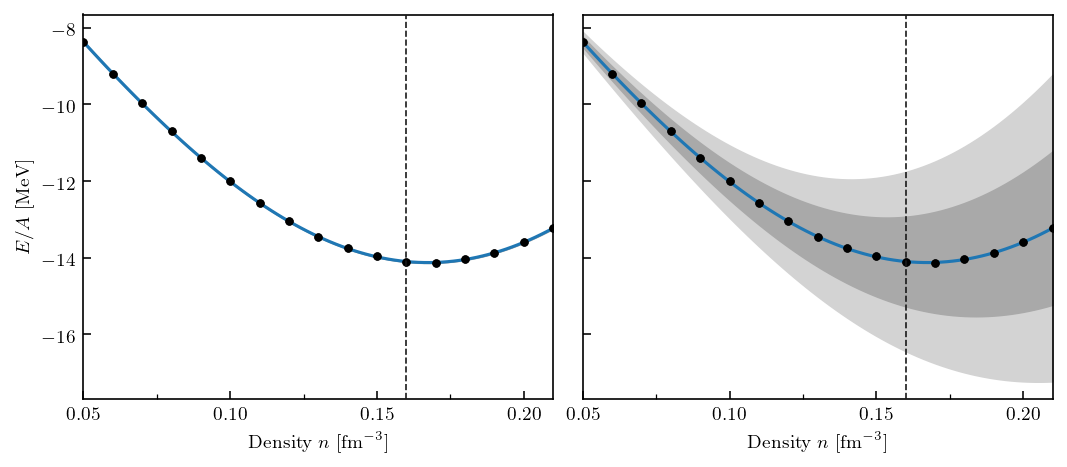

In [48]:
axes = plot_with_and_without_truncation(
    density_all,
    obs_nuclear.get_pred(order=4, deriv=0),
    obs_nuclear.get_std(order=4, deriv=0, include_trunc=False),
    obs_nuclear.get_std(order=4, deriv=0, include_trunc=True),
    density_data=density,
    y_data=y_s_2_plus_3bf[:, -1]
)
fig = plt.gcf()
axes[0].set_ylabel(r'$E/A$ [MeV]');

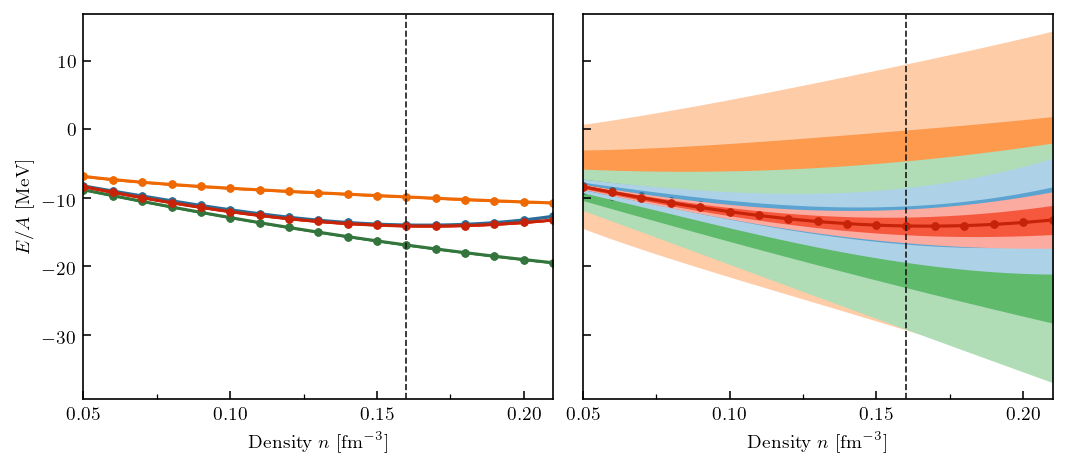

In [49]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(7, 3))
for i, n in enumerate(orders):
    plot_with_and_without_truncation(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=0),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=False),
        obs_nuclear.get_std(order=n, deriv=0, include_trunc=True),
        density_data=density,
#         y_data=y_s_2_plus_3bf[:, i],
        y_data=obs_nuclear.poly_interp(order=n, deriv=0),
        axes=axes,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==0,
        zorder=i/10
    )
fig = plt.gcf()
axes[0].set_ylabel(r'$E/A$ [MeV]');

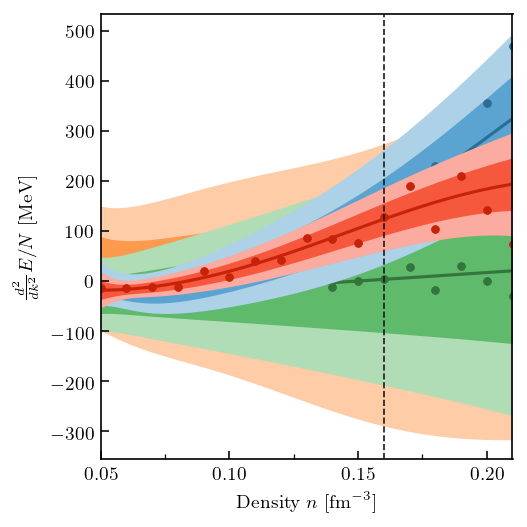

In [50]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(orders):
    plot_obs_vs_density(
        density_all,
        obs_nuclear.get_pred(order=n, deriv=2),
        obs_nuclear.get_std(order=n, deriv=2, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==0,
        zorder=i/10,
        density_data=density,
        y_data=obs_nuclear.finite_difference(order=n, deriv=2, wrt_kf=True),
#         y_data=obs_nuclear.poly_interp(order=n, deriv=2, density=obs_nuclear.density) / \
#             kf_derivative_wrt_density(obs_nuclear.kf, obs_nuclear.density),
    )
ax.set_ylabel(r'$\frac{d^2}{dk^2} E/N$ [MeV]');

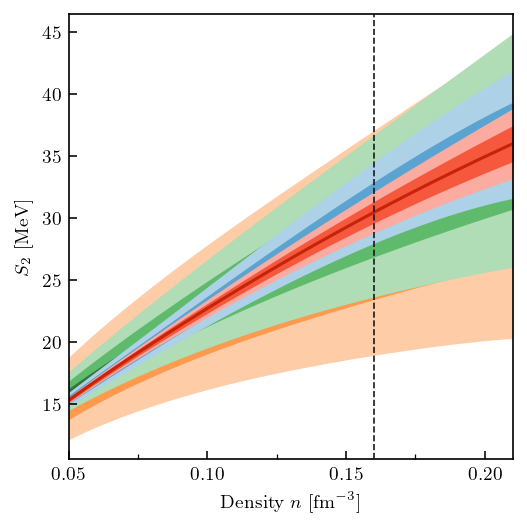

In [51]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(orders):
    plot_obs_vs_density(
        density_all,
        obs_sym_energy.get_pred(order=n, deriv=0),
        obs_sym_energy.get_std(order=n, deriv=0, include_trunc=True),
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==0,
        zorder=i/10
    )
ax.set_ylabel(r'$S_2$ [MeV]');

In [52]:
# axes = plot_with_and_without_truncation(
#     density_all, y_s_star_vecs[0], std_s_star_vecs[0],
#     std_s_total_vecs[0], density_data=density,
#     y_data=y_s_2_plus_3bf[:, -1]
# );
# axes[0].set_ylabel(r'$E/A$ [MeV]');


In [53]:
# axes = plot_with_and_without_truncation(
#     density_all, y_s_star_vecs[1], std_s_star_vecs[1],
#     std_s_total_vecs[1],
# );
# for ax in axes:
#     ax.axhline(0, 0, 1, c='lightgrey', zorder=-1)
# axes[0].set_ylabel(r'$\frac{d}{dk} E/A$ [MeV]');

In [54]:
from nuclear_matter import kf_derivative_wrt_density

In [55]:
# _d_kf_s_all = kf_derivative_wrt_density(kf_s_all, density_all)
# axes = plot_with_and_without_truncation(
#     density_all, _d_kf_s_all * y_s_star_vecs[1], _d_kf_s_all * std_s_star_vecs[1],
#     _d_kf_s_all * std_s_total_vecs[1],
# );
# for ax in axes:
#     ax.axhline(0, 0, 1, c='lightgrey', zorder=-1)
# axes[0].set_ylabel(r'$\frac{d}{dn} E/A$ [MeV]');

In [56]:
# fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
# ax1, ax2 = axes
# # ax1.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
# curve_plus_bands_plot(ax1, kf_s_all, y_s_star, std_s_star)
# ax1.set_title('Interpolant')
# ax1.set_xlabel(r'$k_f$ [fm$^{-1}$]')
# ax1.set_ylabel(r'$E/A$ [MeV]')

# # ax2.plot(kf_s, y_s[:, -1], ls='', marker='o', c='k');
# curve_plus_bands_plot(ax2, kf_s_all, y_s_star, std_s_total_star)
# ax2.set_title('+ Truncation Error')
# ax2.set_xlabel(r'$k_f$ [fm$^{-1}$]')
# fig.tight_layout()

In [57]:
# axes = plot_with_and_without_truncation(
#     density_all, y_n_star_vecs[0], std_n_star_vecs[0],
#     std_n_total_vecs[0], density_data=density,
#     y_data=y_n_2_plus_3bf[:, -1]
# )
# axes[0].set_ylabel(r'$E/N$ [MeV]');

In [58]:
# axes = plot_with_and_without_truncation(
#     density_all, y_d_star_vecs[0], std_d_star_vecs[0],
#     std_d_total_vecs[0], density_data=density,
#     y_data=y_d_2_plus_3bf[:, -1]
# )
# axes[0].set_ylabel(r'$S_2$ [MeV]');

The pressure is given by
$$ 
P = n^2 \frac{d}{dn} \frac{E}{A} = n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = n \frac{k_f}{3} \frac{d}{dk_f}  \frac{E}{A}
$$
where $k_f = \sqrt[3]{3\pi^2\, n/2}$ ($k_f = \sqrt[3]{3\pi^2\, n}$) for symmetric (neutron) matter.

It is useful to note that
\begin{align}
    \frac{dk}{dn} & = \frac{k}{3n} \\
    \frac{d^2k}{dn^2} & = -\frac{2k}{9n^2}
\end{align}

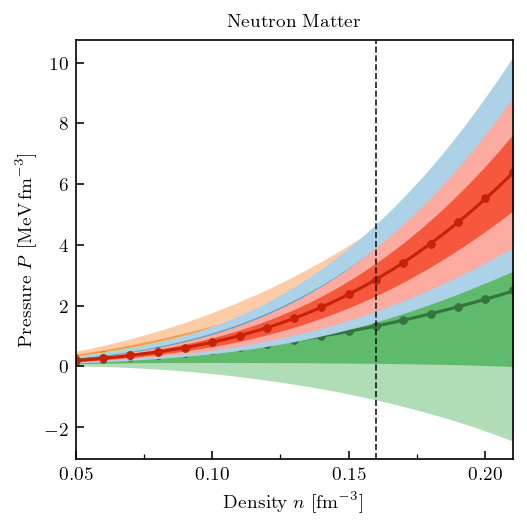

In [59]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 3.4))
for i, n in enumerate(orders):
    pressure_n = compute_pressure(
        obs_neutron.density_interp,
        obs_neutron.kf_interp,
        dE=obs_neutron.get_pred(order=n, deriv=1)
    )
    pressure_n_cov = compute_pressure_cov(
        obs_neutron.density_interp,
        obs_neutron.kf_interp,
        dE_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=1)
    )
    pressure_n_std = np.sqrt(np.diag(pressure_n_cov))
    
    # Try both derivatives:
#     pressure_alt_diff_n = compute_pressure(
#         obs_neutron.density,
#         obs_neutron.kf,
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True)
#     )
#     pressure_alt_diff_n = compute_pressure(
#         obs_neutron.density,
#         obs_neutron.kf,
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=False),
#         wrt_kf=False
#     )
    
    pressure_alt_diff_n = compute_pressure(
        obs_neutron.density,
        obs_neutron.kf,
        dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
        wrt_kf=False
    )
    
    plot_obs_vs_density(
        density_all,
        pressure_n,
        pressure_n_std,
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==0,
        zorder=i/10,
        density_data=obs_neutron.density,
        y_data=pressure_alt_diff_n,
    )
ax.set_title('Neutron Matter')
ax.set_ylabel('Pressure $P$ [MeV\,fm$^{-3}$]');

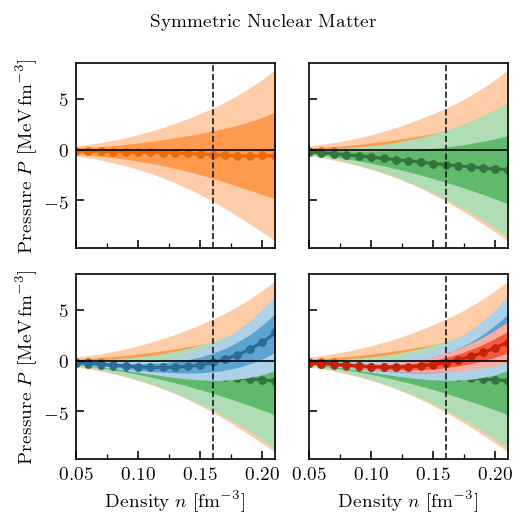

In [60]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex='col', figsize=(3.4, 3.4))
for j, ax in enumerate(axes.ravel()):
    for i, n in enumerate(orders[:j+1]):
        pressure_s = compute_pressure(
            obs_nuclear.density_interp,
            obs_nuclear.kf_interp,
            dE=obs_nuclear.get_pred(order=n, deriv=1)
        )
        pressure_s_cov = compute_pressure_cov(
            obs_nuclear.density_interp,
            obs_nuclear.kf_interp,
            dE_cov=obs_nuclear.get_cov(order=n, deriv1=1, deriv2=1)
        )
        pressure_s_std = np.sqrt(np.diag(pressure_s_cov))

        pressure_alt_diff_s = compute_pressure(
            obs_nuclear.density,
            obs_nuclear.kf,
            dE=obs_nuclear.finite_difference(order=n, deriv=1, wrt_kf=True)
        )

        plot_obs_vs_density(
            density_all,
            pressure_s,
            pressure_s_std,
            ax=ax,
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            density_data=obs_nuclear.density,
            y_data=pressure_alt_diff_s,
            markersize=3,
        )
    ax.axhline(0, 0, 1, c='k', lw=0.8)
fig.suptitle('Symmetric Nuclear Matter')
axes[0,0].set_ylabel('Pressure $P$ [MeV\,fm$^{-3}$]')
axes[1,0].set_ylabel('Pressure $P$ [MeV\,fm$^{-3}$]')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('');

$$
L(n) = 3\,n \, \frac{d}{dn} E_\text{sym}(n) = 3n \frac{dk_f}{dn} \frac{d}{dn} E_\text{sym}(n)
     = 3\,n \, \frac{k_f}{3n} \frac{d}{dk_f}  E_\text{sym}(n) = k_f \frac{d}{dk_f} E_\text{sym}(n)
$$

Text(0.5, 0, '')

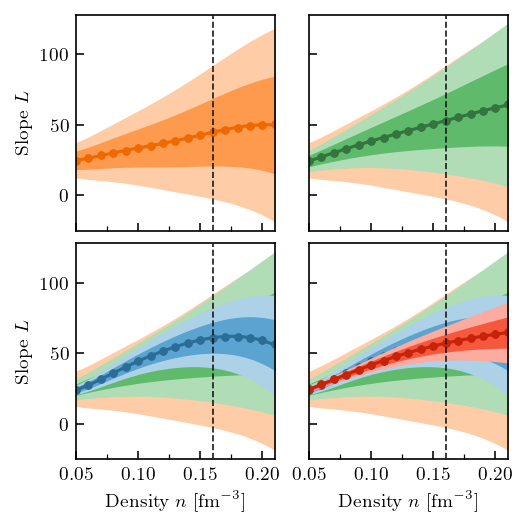

In [61]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex='col', figsize=(3.4, 3.4))
for j, ax in enumerate(axes.ravel()):
    for i, n in enumerate(orders[:j+1]):
        slope = compute_slope(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2=obs_sym_energy.get_pred(order=n, deriv=1)
        )
        slope_cov = compute_slope_cov(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2_cov=obs_sym_energy.get_cov(order=n, deriv1=1, deriv2=1)
        )
        slope_std = np.sqrt(np.diag(slope_cov))

    #     slope_alt_diff = compute_slope(
    #         obs_sym_energy.density,
    #         obs_sym_energy.kf,
    #         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
    #     )
    #     slope_alt_diff = compute_slope(
    #         obs_sym_energy.density,
    #         obs_sym_energy.kf,
    #         dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=False),
    #         wrt_kf=False
    #     )
        slope_alt_diff = compute_slope(
            obs_sym_energy.density,
            obs_sym_energy.kf,
            dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False
        )

        plot_obs_vs_density(
            density_all,
            slope,
            slope_std,
            ax=ax,
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            density_data=obs_sym_energy.density,
            y_data=slope_alt_diff,
            markersize=3,
        )

axes[0,0].set_ylabel('Slope $L$')
axes[1,0].set_ylabel('Slope $L$')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
# fig.canvas.draw()
# print(axes[0,0].get_xticks())
# axes[1,1].set_xticks(axes[0,0].get_xticks()[1:-1])

<!-- $$ 
K(n) = 9 \, n^2 \frac{d}{dn} \frac{E}{A} = 9 \, n^2 \frac{dk_f}{dn} \frac{d}{dk_f}  \frac{E}{A} = 9 \, n^2 \frac{k_f}{3n} \frac{d}{dk_f}  \frac{E}{A} = 3 \, n \, k_f \frac{d}{dk_f}  \frac{E}{A}
$$ -->

\begin{align}
    K(n) = 9 n^2 \frac{d^2}{dn^2} \frac{E}{A} = 9 n^2 \left[\frac{d^2k_f}{dn^2} \left(\frac{d}{dk_f} \frac{E}{A}\right) + \left(\frac{dk_f}{dn}\right)^2 \frac{d^2}{dk_f^2} \frac{E}{A} \right]
\end{align}

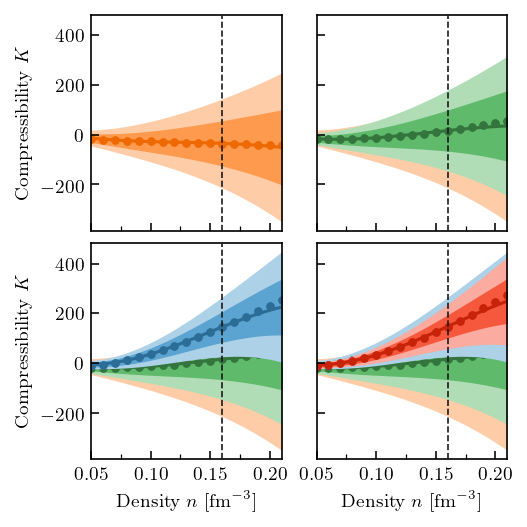

In [62]:
fig, axes = plt.subplots(2, 2, sharey=True, sharex='col', figsize=(3.4, 3.4))
for j, ax in enumerate(axes.ravel()):
    for i, n in enumerate(orders[:j+1]):
        K_incomp = compute_compressibility(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            d2E=obs_neutron.get_pred(order=n, deriv=2),
            dE=obs_neutron.get_pred(order=n, deriv=1),
        )
        K_incomp_cov = compute_compressibility_cov(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            d2E_cov=obs_neutron.get_cov(order=n, deriv1=2, deriv2=2),
            dE_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=1),
            dE_d2E_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=2),
        )
        K_incomp_std = np.sqrt(np.diag(K_incomp_cov))

        # Derivative wrt kf and n differ!
    #     K_incomp_alt_diff = compute_compressibility(
    #         obs_neutron.density,
    #         obs_neutron.kf,
    #         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
    #         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
    #     )
    #     K_incomp_alt_diff = compute_compressibility(
    #         obs_neutron.density,
    #         obs_neutron.kf,
    #         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
    #         wrt_kf=False
    #     )
        K_incomp_alt_diff = compute_compressibility(
            obs_neutron.density,
            obs_neutron.kf,
            d2E=obs_neutron.poly_interp(order=n, deriv=2, wrt_kf=False),
            wrt_kf=False
        )

        plot_obs_vs_density(
            obs_neutron.density_interp,
            K_incomp,
            K_incomp_std,
            ax=ax,
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            density_data=obs_neutron.density,
            y_data=K_incomp_alt_diff
        )
axes[0,0].set_ylabel('Compressibility $K$')
axes[1,0].set_ylabel('Compressibility $K$')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('');

In [63]:
def compute_Esym_L(kf, S2_dS2, S2_dS2_cov):
    to_Esym_L_mat = np.array([
        [1, 0],
        [0, kf]
    ])
    S2_L = to_Esym_L_mat @ S2_dS2
    S2_L_cov = to_Esym_L_mat @ S2_dS2_cov @ to_Esym_L_mat.T
    return S2_L, S2_L_cov

In [64]:
density_sat = np.array([0.16])
Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.

Esym_dEsym_mean_16, Esym_dEsym_cov_16 = obs_sym_energy.predict(Kf_d_sat, order=4, derivs=[0, 1])
Esym_L_mean_16, Esym_L_cov_16 = compute_Esym_L(Kf_d_sat[0,0], Esym_dEsym_mean_16, Esym_dEsym_cov_16)

In [65]:
np.random.seed(1)

num_sats = 101
d_sats = stats.norm(0.17, 0.01).rvs(num_sats)
K_n_sats = fermi_momentum(d_sats, 2)[:, None]
K_s_sats = fermi_momentum(d_sats, 4)[:, None]
K_d_sats = (K_n_sats + K_s_sats) / 2.
Esym_dEsym_means, Esym_dEsym_cov = obs_sym_energy.predict(K_d_sats, order=4, derivs=[0, 1])

Esym_L_samples = []
for n_s in range(num_sats):
    # Get S2(kf_i) and dS2(kf_i). The vector and matrices are blocks for each derivative type
    Esym_dEsym_mean_n = Esym_dEsym_means[[n_s, n_s+num_sats]]
    Esym_dEsym_cov_n = Esym_dEsym_cov[[n_s, n_s+num_sats]][:, [n_s, n_s+num_sats]]
    Esym_L_mean_n, Esym_L_cov_n = compute_Esym_L(K_d_sats[n_s,0], Esym_dEsym_mean_n, Esym_dEsym_cov_n)
    Esym_L_samples.append(stats.multivariate_normal(mean=Esym_L_mean_n, cov=Esym_L_cov_n).rvs(num_sats))
Esym_L_samples = np.asarray(Esym_L_samples).reshape(-1, 2).T

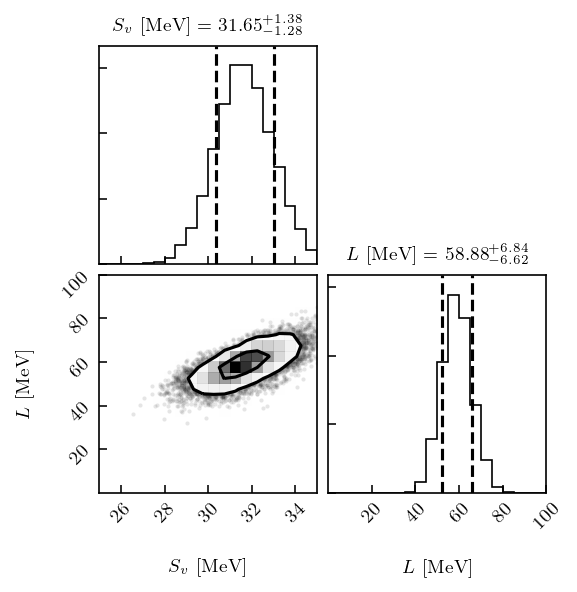

In [66]:
# plt.scatter(*Esym_L_samples)
fig, axes = plt.subplots(2, 2, figsize=(4, 4), constrained_layout=False)
fig = corner.corner(
    Esym_L_samples.T, range=[(25, 35), (0, 100)],
    labels=[r'$S_v$ [MeV]', r'$L$ [MeV]'], fig=fig,
    quantiles=(0.16, 0.84), levels=(1-np.exp(-0.5), 1-np.exp(-0.5*2**2)),
    show_titles=True, title_kwargs={"fontsize": 9}
)

In [67]:
Esym_L_samples_mean = np.mean(Esym_L_samples, axis=1)
Esym_L_samples_cov = np.cov(Esym_L_samples)

In [68]:
Esym_L_samples_mean

array([31.69096099, 58.95712712])

In [69]:
Esym_L_samples_cov

array([[ 1.82100168,  6.37599397],
       [ 6.37599397, 46.7033256 ]])

In [70]:
Esym_L_mean_16

array([30.47719966, 57.10636686])

In [71]:
Esym_L_cov_16

array([[ 0.62659203,  3.77143998],
       [ 3.77143998, 33.44586939]])

In [72]:
np.linalg.eigh(Esym_L_cov_16)

(array([ 0.19877244, 33.87368899]),
 array([[-0.9936275 ,  0.11271379],
        [ 0.11271379,  0.9936275 ]]))

Ellipse(xy=(0, 0), width=2.7009933209555026, height=0.8394254464535637, angle=0)


(0, 100)

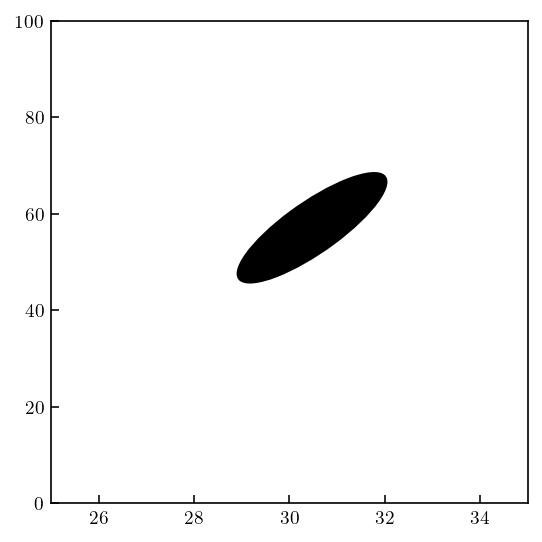

In [73]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))
pat = confidence_ellipse_mean_cov(Esym_L_mean_16, Esym_L_cov_16, ax=ax, n_std=2, facecolor='k')
print(pat)
ax.set_xlim(25, 35)
ax.set_ylim(0, 100)

In [74]:

# density_sat = np.array([0.16, 0.16])
# Kf_n_sat = fermi_momentum(density_sat, 2)[:, None]
# Kf_s_sat = fermi_momentum(density_sat, 4)[:, None]
# # Kf_d_sat = (Kf_n_sat + Kf_s_sat) / 2.
# Kf_d_sat = Kf_n_sat
# Esym_L_sat_derivs = np.array([[0], [1]])
# y_d_sat, cov_d_sat_lower = gp_d_lower.predict(Kf_d_sat, n=Esym_L_sat_derivs, return_cov=True)

# # cov_d_sat_upper = kernel_upper_d(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)
# cov_d_sat_upper = gp_d_upper.compute_Kij(Kf_d_sat, Kf_d_sat, ni=Esym_L_sat_derivs, nj=Esym_L_sat_derivs)

# to_Esym_L_mat = np.array([
#     [1, 0],
#     [0, Kf_d_sat[0,0]]
# ])

# Esym_L_sat = to_Esym_L_mat @ y_d_sat
# cov_Esym_L = to_Esym_L_mat @ (cov_d_sat_upper + cov_d_sat_lower) @ to_Esym_L_mat.T
# # mvn_d_sat = stats.multivariate_normal(mean=y_d_sat, cov=cov_Esym_L)
# # Esym_L_samples = mvn_d_sat.rvs(100)
# # plt.scatter(*Esym_L_samples.T)


In [75]:
# fig, ax = plt.subplots(figsize=(3.5, 3.5))
# confidence_ellipse(Esym_L_sat, cov_Esym_L, ax=ax, n_std=2, facecolor='k')
# ax.set_xlim(25, 35)
# ax.set_ylim(0, 100)

In [76]:
# to_incomp_factor = kf_s_all * 3 * density_all

# d2kf_s_dn2 = -2 * kf_s_all / (9 * density_all**2)
# dkf_s_dn = kf_s_all / (3 * density_all)

# # incomp = y_s_star_prime * to_incomp_factor
# # incomp_std = std_s_total_star_prime * to_incomp_factor
# incomp = 9 * density_all**2 * (d2kf_s_dn2 * y_s_star_prime + dkf_s_dn**2 * y_s_star_prime2)
# incomp_std = 9 * density_all**2 * np.sqrt(
#     (d2kf_s_dn2 * std_s_total_star_prime)**2 + (dkf_s_dn**2 * std_s_total_star_prime2)**2 +
#     2 * d2kf_s_dn2 * dkf_s_dn**2 * var_s_total_star_cov_prime_prime2
# )

# fig, ax = plt.subplots(figsize=(3.4, 3.4))
# ax2 = ax.twiny() # axis for kf
# curve_plus_bands_plot(ax, density_all, incomp, incomp_std)
# highlight_nsat(ax)

# # set labels and title
# ax.set_xlabel(r"Density $n$ [fm$^{-3}$]")
# ax.set_ylabel(r'Incompressibility $K$ [MeV]')
# ax2.set_xlabel(r'Fermi momentum $k_f$ [fm$^{-1}$]')
# ax.set_title('Incompressibility + Truncation Error')

# # set limits and ticks for kf axis
# kfTickLocations = np.array([1.0, 1.1, 1.2, 1.3, 1.4])
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(nuclear_density(kfTickLocations,4))
# ax2.set_xticklabels(kfTickLocations)

# fig.tight_layout();

## Speed of sound in neutron matter

\begin{align}
c_S^2 & = \frac{\partial P}{\partial \varepsilon} = \frac{\partial P}{\partial n} \left[ \frac{\partial \varepsilon}{\partial n}\right]^{-1} = \frac{\partial P}{\partial n} \left[ \frac{E}{N} + m + n \, \frac{\partial }{\partial n} \frac{E}{N} \right]^{-1} \\
\frac{\partial P}{\partial n} & = 2n \frac{d}{dn} \frac{E}{N} + n^2 \frac{d^2}{dn^2} \frac{E}{N} \\
& = \frac{2P}{n} + \frac{K}{9}
\end{align}
Here, the energy density $\varepsilon = n \left( \frac{E}{N} + m \right)$ includes the rest-mass contribution.

In [77]:
from nuclear_matter.matter import mass_neutron

In [78]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, MaxNLocator
import matplotlib.patches as mpatches

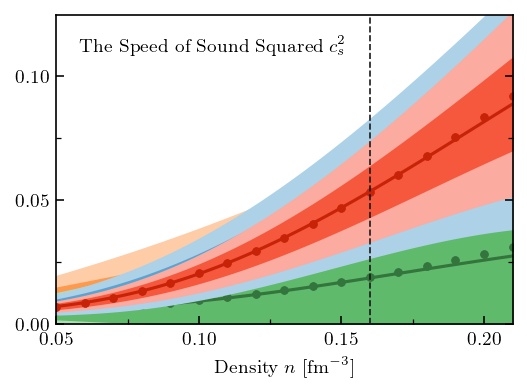

In [79]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(3.4, 2.5))
for i, n in enumerate(orders):
    E_per_N_samples_n = obs_neutron.draw_sample(order=n, num_samp=500)
    speed_of_sound_samples = compute_speed_of_sound(
        obs_neutron.density_interp,
        obs_neutron.kf_interp,
        E=E_per_N_samples_n[0].T,
        dE=E_per_N_samples_n[1].T,
        d2E=E_per_N_samples_n[2].T,
        mass=mass_neutron
    )
    speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=True),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=True),
#         mass=mass_neutron
#     )
#     speed_of_sound_alt_diff = compute_speed_of_sound(
#         obs_neutron.density,
#         obs_neutron.kf,
#         E=obs_neutron.finite_difference(order=n, deriv=0, wrt_kf=False),
#         dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=False),
#         d2E=obs_neutron.finite_difference(order=n, deriv=2, wrt_kf=False),
#         mass=mass_neutron,
#         wrt_kf=False,
#     )
    speed_of_sound_alt_diff = compute_speed_of_sound(
        obs_neutron.density,
        obs_neutron.kf,
        E=obs_neutron.poly_interp(order=n, deriv=0, wrt_kf=False),
        dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
        d2E=obs_neutron.poly_interp(order=n, deriv=2, wrt_kf=False),
        mass=mass_neutron,
        wrt_kf=False,
    )
    
    plot_obs_vs_density(
        density_all,
        speed_of_sound_mean,
        speed_of_sound_std,
        ax=ax,
        color_68=colors[i],
        color_95=light_colors[i],
        c=dark_colors[i],
        add_nsat=i==0,
        zorder=i/10,
        density_data=obs_neutron.density,
        y_data=speed_of_sound_alt_diff,
        
    )
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_ylim(0, 0.125)
ax.tick_params(right=True, which='both')
ax.text(0.05, 0.92, s='The Speed of Sound Squared $c_s^2$', transform=ax.transAxes, ha='left', va='top');
fig.savefig('speed_of_sound')
# ax.set_ylabel('Speed of Sound');

In [80]:
from matplotlib import legend_handler
from matplotlib.legend_handler import HandlerLine2D

class OrderBandsHandler:
    
#     def __init__(self, edgecolor, facecolor, facecolor2=None, **kwargs):
#         if facecolor2 is None:
#             facecolor2 = facecolor
            
#         self.edgecolor = edgecolor
#         self.facecolor = facecolor
#         self.facecolor2 = facecolor2
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print('hello!', flush=True)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        
        light_rect = orig_handle[0]
        dark_rect = orig_handle[1]
        dark_line = orig_handle[2]
        
        light_color = light_rect.get_facecolor()[0]
        color = dark_rect.get_facecolor()[0]
        dark_color = dark_line.get_color()
        
        
        patch_outer = mpatches.Rectangle(
            [x0, y0], width, height, facecolor=light_color,
            edgecolor=dark_color, lw=1,
            transform=handlebox.get_transform()
        )
        patch_inner = mpatches.Rectangle(
            [x0, y0+height/4], width, height/2, facecolor=color,
            edgecolor=dark_color, lw=0,
            transform=handlebox.get_transform()
        )
        handlebox.add_artist(patch_outer)
        handlebox.add_artist(patch_inner)
        handlebox.add_artist(dark_line)
        return patch_outer, patch_inner, dark_line
    
    
class OrderBandsHandler2(legend_handler.HandlerPolyCollection):
        
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        
        light_rect = orig_handle[0]
        dark_rect = orig_handle[1]
        dark_line = orig_handle[2]
        dark_color = dark_line.get_color()
        color = dark_rect.get_facecolor()[0]
        light_color = light_rect.get_facecolor()[0]
        lw = 0.8

        outer_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor='none', edgecolor=dark_color,
            lw=lw
        )
        dark_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor=color, edgecolor='none',
            lw=0
        )
        light_rect = mpatches.Rectangle(
            [0, 0], 1, 1, facecolor=light_color, edgecolor='none',
            lw=0
        )
        
        patches = []
        
        factor = 2
#         patches += super().create_artists(legend, light_rect, xdescent, ydescent, width, height, fontsize, trans)
#         patches += super().create_artists(
#             legend, dark_rect, xdescent, ydescent-height/(2*factor), width, height/factor, fontsize, trans)
        patches += legend_handler.HandlerPatch().create_artists(
            legend, light_rect, xdescent, ydescent, width, height, fontsize, trans)
        patches += legend_handler.HandlerPatch().create_artists(
            legend, dark_rect, xdescent, ydescent-height/(2*factor), width, height/factor, fontsize, trans)
        
        outer_patches = legend_handler.HandlerPatch().create_artists(
            legend, outer_rect, xdescent, ydescent, width, height, fontsize, trans)
        outer_patches[0].set_linewidth(lw/2)
        patches += outer_patches
        
        line_patches = HandlerLine2D().create_artists(
            legend, dark_line, xdescent, ydescent, width, height, fontsize, trans)
        line_patches[0].set_linewidth(lw)
        patches += line_patches
        
        return patches
    

def compute_filled_handles(colors, light_colors, dark_colors,):
    handles = []
    for color, light_color, dark_color in zip(colors, light_colors, dark_colors):
        fill_light = plt.fill_between([], [], [], alpha=1, color=light_color)
        fill_normal = plt.fill_between([], [], [], alpha=1, color=color)
        line_dark = plt.plot([], [], color=dark_color, dash_capstyle='butt', solid_capstyle='butt')[0]

        handles.append((fill_light, fill_normal, line_dark))
    return handles

/Users/jordan.melendez/opt/miniconda3/envs/nuclear-matter/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


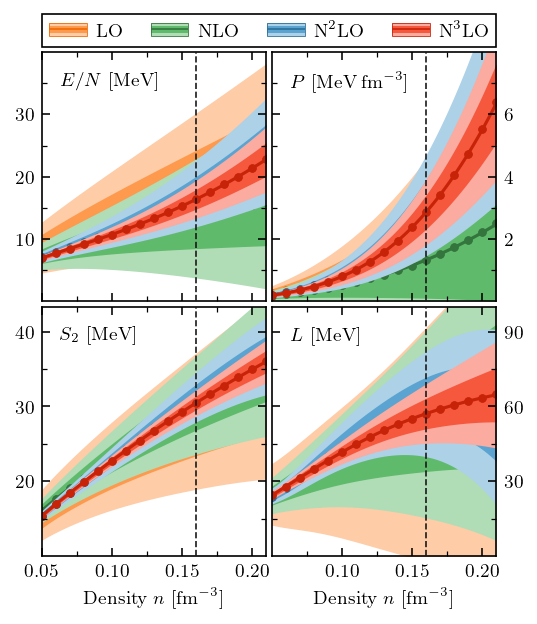

In [81]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    # fig, axes = plt.subplots(1, 3, sharey=False, sharex=True, figsize=(7, 3))
    # ax_EN = axes[0]
    # ax_S2 = axes[1]
    # ax_cs = axes[2]

    text_kwargs = dict(x=0.08, y=0.92, ha='left', va='top')

    fig, axes = plt.subplots(2, 2, sharey=False, sharex='col', figsize=(3.4, 4), constrained_layout=True)
    ax_EN = axes[0, 0]
    ax_S2 = axes[1, 0]
    # ax_cs = axes[1, 0]
    ax_P = axes[0, 1]
    ax_L = axes[1, 1]
    
    ms_4x4 = 3


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_neutron.get_pred(order=n, deriv=0),
            obs_neutron.get_std(order=n, deriv=0, include_trunc=True),
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            ax=ax_EN,
            density_data=obs_neutron.density,
            y_data=obs_neutron.finite_difference(order=n, deriv=0),
            markersize=ms_4x4,
        )
    ax_EN.text(s=r'$E/N$ [MeV]', transform=ax_EN.transAxes, **text_kwargs)
    ax_EN.set_ylim(1e-5, 40-1e-5)


    for i, n in enumerate(orders):
        plot_obs_vs_density(
            density_all,
            obs_sym_energy.get_pred(order=n, deriv=0),
            obs_sym_energy.get_std(order=n, deriv=0, include_trunc=True),
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            ax=ax_S2,
            density_data=obs_sym_energy.density,
            y_data=obs_sym_energy.finite_difference(order=n, deriv=0),
            markersize=ms_4x4,
        )
    # ax_S2.set_title(r'$S_2$ [MeV]');
    ax_S2.text(s=r'$S_2$ [MeV]', transform=ax_S2.transAxes, **text_kwargs)
    ax_S2.yaxis.set_major_locator(MultipleLocator(10))
    ax_S2.set_ylim(10+1e-5, 43.33333)


    # for i, n in enumerate(orders):
    #     E_per_N_samples_n = obs_neutron.draw_sample(order=n, num_samp=500)
    #     speed_of_sound_samples = compute_speed_of_sound(
    #         obs_neutron.density_interp,
    #         obs_neutron.kf_interp,
    #         E=E_per_N_samples_n[0].T,
    #         dE=E_per_N_samples_n[1].T,
    #         d2E=E_per_N_samples_n[2].T,
    #         mass=mass_neutron
    #     )
    #     speed_of_sound_mean = np.nanmean(speed_of_sound_samples, axis=0)
    #     speed_of_sound_std = np.nanstd(speed_of_sound_samples, axis=0)
    #     plot_obs_vs_density(
    #         density_all,
    #         speed_of_sound_mean,
    #         speed_of_sound_std,
    #         color_68=colors[i],
    #         color_95=light_colors[i],
    #         c=dark_colors[i],
    #         add_nsat=i==0,
    #         zorder=i/10,
    #         ax=ax_cs
    #     )
    # # axes[2].set_title('Speed of Sound');
    # ax_cs.text(0.05, 0.95, r'$c_s^2$', transform=ax_cs.transAxes, ha='left', va='top')
    # ax_cs.set_ylim(0, None)
    # ax_cs.yaxis.set_major_locator(MultipleLocator(0.05))
    # ax_cs.yaxis.set_minor_locator(AutoMinorLocator(2))



    for i, n in enumerate(orders):
        pressure_n = compute_pressure(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE=obs_neutron.get_pred(order=n, deriv=1)
        )
        pressure_n_cov = compute_pressure_cov(
            obs_neutron.density_interp,
            obs_neutron.kf_interp,
            dE_cov=obs_neutron.get_cov(order=n, deriv1=1, deriv2=1)
        )
        pressure_n_std = np.sqrt(np.diag(pressure_n_cov))
        
#         pressure_alt_diff_n = compute_pressure(
#             obs_neutron.density,
#             obs_neutron.kf,
#             dE=obs_neutron.finite_difference(order=n, deriv=1, wrt_kf=True)
#         )
        pressure_alt_diff_n = compute_pressure(
            obs_neutron.density,
            obs_neutron.kf,
            dE=obs_neutron.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False
        )
        
        plot_obs_vs_density(
            density_all,
            pressure_n,
            pressure_n_std,
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            ax=ax_P,
            density_data=obs_neutron.density,
            y_data=pressure_alt_diff_n,
            markersize=ms_4x4,
        )
    # ax_P.axhline(0, 0, 1, c='k', lw=0.4, zorder=1)
    # ax_P.set_title('Symmetric Nuclear Matter')
    # ax_P.set_ylabel('Pressure $P$ [MeV\,fm$^{-3}$]');
    ax_P.text(s=r'$P$ [MeV\,fm$^{-3}$]', transform=ax_P.transAxes, **text_kwargs)
    ax_P.set_ylim(0+1e-5, 8-1e-5)




    for i, n in enumerate(orders):
        slope = compute_slope(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2=obs_sym_energy.get_pred(order=n, deriv=1)
        )
        slope_cov = compute_slope_cov(
            obs_sym_energy.density_interp,
            obs_sym_energy.kf_interp,
            dS2_cov=obs_sym_energy.get_cov(order=n, deriv1=1, deriv2=1)
        )
        slope_std = np.sqrt(np.diag(slope_cov))
        
#         slope_alt_diff = compute_slope(
#             obs_sym_energy.density,
#             obs_sym_energy.kf,
#             dS2=obs_sym_energy.finite_difference(order=n, deriv=1, wrt_kf=True)
#         )
        slope_alt_diff = compute_slope(
            obs_sym_energy.density,
            obs_sym_energy.kf,
            dS2=obs_sym_energy.poly_interp(order=n, deriv=1, wrt_kf=False),
            wrt_kf=False,
        )
        
        plot_obs_vs_density(
            density_all,
            slope,
            slope_std,
            color_68=colors[i],
            color_95=light_colors[i],
            c=dark_colors[i],
            add_nsat=i==0,
            zorder=i/10,
            ax=ax_L,
            density_data=obs_sym_energy.density,
            y_data=slope_alt_diff,
            markersize=ms_4x4,
        )
    # ax_L.set_ylabel('Slope $L$ [MeV]');
    ax_L.text(s=r'$L$ [MeV]', transform=ax_L.transAxes, **text_kwargs)
    ax_L.yaxis.set_major_locator(MultipleLocator(30))
    ax_L.set_ylim(0+1e-5, 100)


    for i in range(axes.shape[0]):
        for j in range(axes.shape[1]):
            ax = axes[i, j]
            if j == 1:
                ax.yaxis.tick_right()
                ax.set_xticks(axes[0, 0].get_xticks()[2:-1])
    #             ax.xaxis.set_major_locator(MaxNLocator(nbins=3, steps=[0.05, 0.1, 0.15, 0.2], prune='lower'))
            if i != 1:
                ax.set_xlabel('')
            ax.tick_params(left=True, bottom=True, right=True, top=True, which='both')
            ax.yaxis.set_minor_locator(AutoMinorLocator(2))


    fig.set_constrained_layout_pads(h_pad=1.3/72, w_pad=0.5/72)
    fig.canvas.draw()  # Must draw to get positions right before getting locations
    # Get the corner of the upper right plot in display coordinates
    upper_right_display = axes[0, 1].transAxes.transform((1, 1))
    # Now put it in axes[0,0] coords
    upper_right_axes00 = axes[0, 0].transAxes.inverted().transform(upper_right_display)
    handlers_ords = compute_filled_handles(colors, light_colors, dark_colors)
    # Must use axes[0,0] legend for constrained layout to work with it
    leg = axes[0,0].legend(
        handlers_ords, ['LO', 'NLO', 'N$^{2}$LO', 'N$^{3}$LO'], ncol=4,
        loc='lower left', bbox_to_anchor=(0, 1.02, upper_right_axes00[0], 1.),
        mode='expand',
        columnspacing=0,
        handletextpad=0.5,
        fancybox=False, borderaxespad=0,
        handler_map={tuple: OrderBandsHandler2()}
    )

    fig.savefig('energies_and_related_derivatives')